In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen
import pandas as pd

In [2]:
parser = Sbopen()
df, related, freeze, players = parser.event(3895074)

In [3]:
# Index der ersten Auswechslung
sub = df.loc[df["type_name"] == "Substitution"].loc[df["team_name"] == "Bayern Munich"].iloc[0]["index"]
# DataFrame mit erfolgreichen Pässen von Bayern München bis zur ersten Auswechslung
mask_england = (df.type_name == 'Pass') & (df.team_name == "Bayern Munich") & (df.index < sub) & (df.outcome_name.isnull()) & (df.sub_type_name != "Throw-in")
# notwendige Spalten
df_pass = df.loc[mask_england, ['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name"]]
# Nur Nachnamen 
df_pass["player_name"] = df_pass["player_name"].apply(lambda x: str(x).split()[-1])
df_pass["pass_recipient_name"] = df_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])

In [4]:
scatter_df = pd.DataFrame()
for i, name in enumerate(df_pass["player_name"].unique()):
    passx = df_pass.loc[df_pass["player_name"] == name]["x"].to_numpy()
    recx = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_pass.loc[df_pass["player_name"] == name]["y"].to_numpy()
    recy = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    scatter_df.at[i, "no"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]

# Größe der Kreise entsprechend der Anzahl der Pässe der Spieler (großer Kreis = viele Pässe)
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

In [5]:
# Anzahl an Pässen zwischen Spielern
df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)

lines_df = lines_df[lines_df['pass_count']>2]

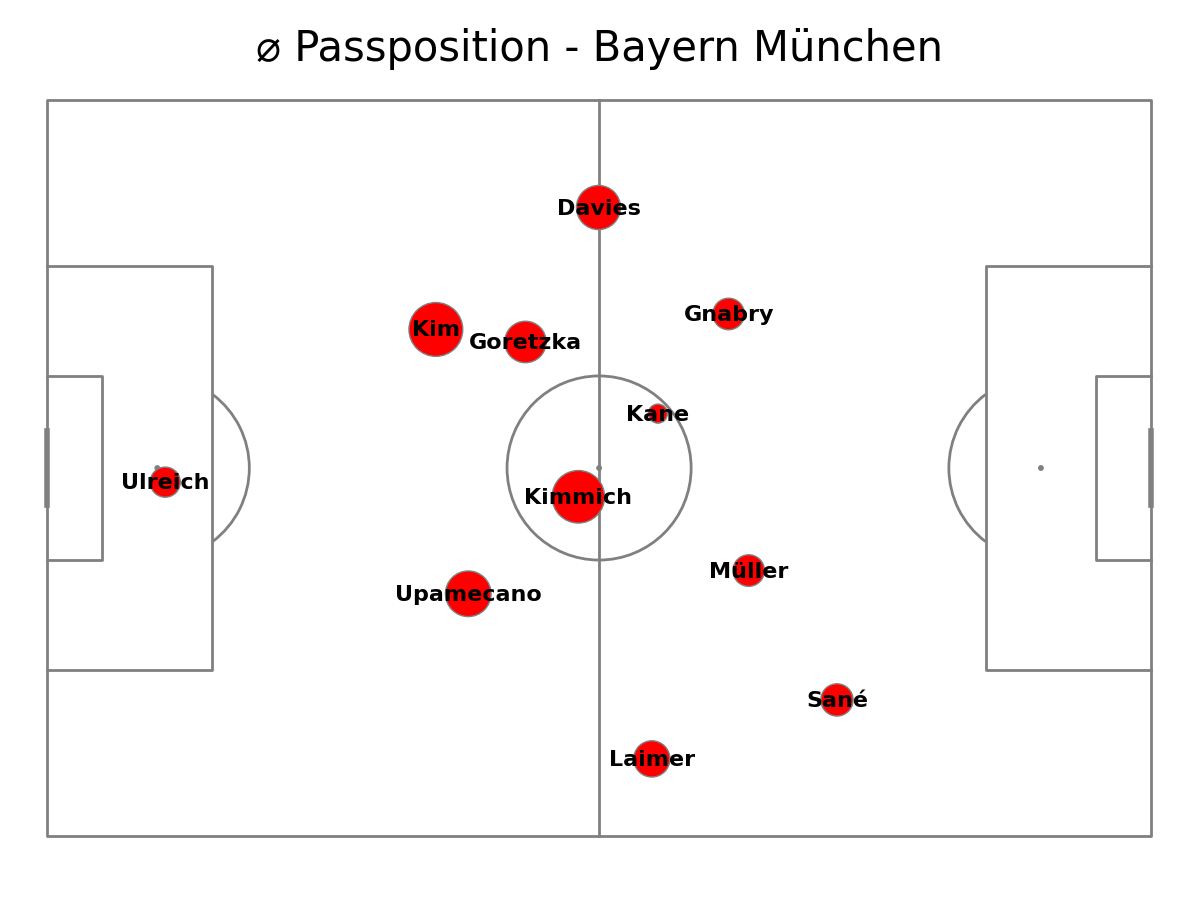

In [6]:
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)

#Beschriftung der Kreise mit Spielernamen
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

fig.suptitle("⌀ Passposition - Bayern München", fontsize = 30)
plt.show()

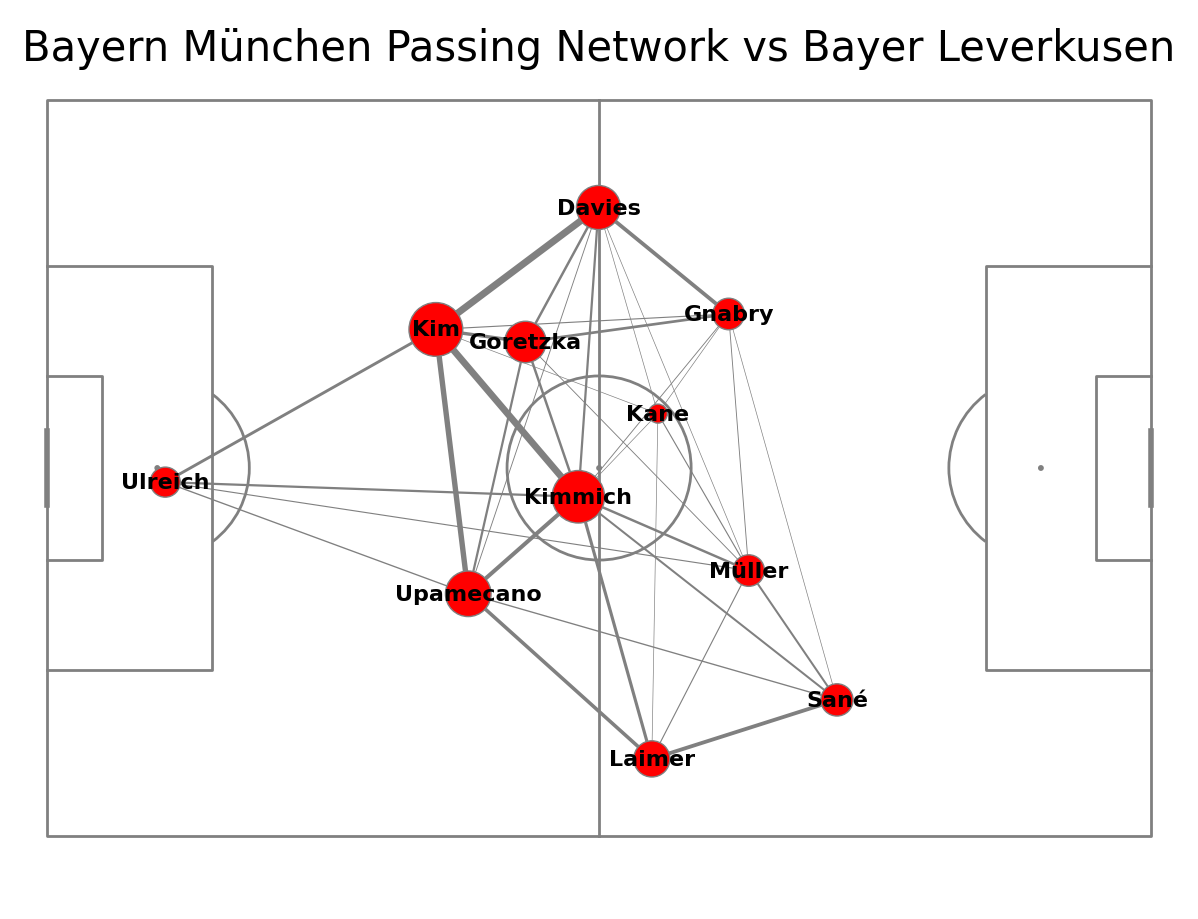

In [7]:
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#Zeichnung der Spielerpositionen
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)

#Beschriftung der Spielernamen
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

# Für jede Spieler-Paarung die Linie zwischen den Positionen zeichnen
for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #durchschnittlicher Standort der Spieler, um eine Linie zeichnen
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #je mehr Pässe, desto breiter die Linie
        line_width = (num_passes / lines_df['pass_count'].max() * 5)
        #Zeichnung der Linien auf das Spielfeld
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=1, lw=line_width, zorder=2, color="grey", ax = ax["pitch"])

fig.suptitle("Bayern München Passing Network vs Bayer Leverkusen", fontsize = 30)
plt.show()